In [2]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, Reshape, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import librosa.display
print("pandas version : ",pd.__version__)
print("numpy version : ",np.version.version)
#if colab
#from google.colab import drive

#drive.mount('/content/drive')
#%cd drive/MyDrive/Colab\ Notebooks

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
# 그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

pandas version :  1.2.3
numpy version :  1.19.2


In [22]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    stft_data = []
    sounds = []
    temp = []
    global s_data, sound_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                #print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                ny = y[:sr*3]
                #print(ny.shape)
                stft = librosa.stft(ny, n_fft=128, hop_length=128, win_length=128).T
                stft = np.abs(stft)
                sounds.append(ny)
                stft_data.append(stft)
                #print("Stft Size : ", stft.shape)
                
    #end loop
    #print("X_data :",np.shape(X_data))
    s_data = stft_data
    sound_data = sounds
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
stft_data = np.array(s_data)
sound_data = np.array(sound_data)
print(sound_data.shape)
stft_data.shape

Foldername : 1 - 20 files
(20, 66150)


(20, 517, 65)

In [28]:
print(sound_data[0])
stft_data[0][100]

[0.         0.         0.         ... 0.00399366 0.00406321 0.0038584 ]


array([1.0597927e-01, 1.4112803e-01, 8.7583676e-02, 3.7521448e-02,
       3.8782850e-02, 3.7611499e-02, 2.2934193e-02, 3.8545222e-03,
       1.1256437e-02, 1.3211038e-02, 1.5806854e-02, 7.5846161e-03,
       1.9436778e-03, 1.5288853e-03, 1.4703822e-03, 1.8345336e-03,
       1.5009630e-04, 6.9399521e-04, 6.8250403e-04, 1.0401953e-03,
       7.2420889e-04, 5.8555405e-04, 7.6894794e-04, 3.4450580e-04,
       2.2521090e-04, 7.7133664e-05, 2.4862142e-04, 1.7263670e-04,
       2.3398046e-04, 2.0873816e-04, 1.4482804e-04, 1.4498815e-04,
       9.4971823e-05, 1.6112895e-04, 3.1206160e-04, 2.5094472e-04,
       1.2180474e-04, 1.5647164e-04, 7.6910816e-05, 5.3549495e-05,
       8.2634375e-05, 1.2992710e-04, 2.1572060e-04, 9.0762638e-05,
       1.2009193e-04, 4.3984062e-05, 1.2068650e-04, 7.4433003e-05,
       1.0838074e-04, 1.8851830e-04, 2.2122456e-04, 1.9341186e-04,
       2.2803004e-04, 2.7921802e-04, 1.3809527e-04, 1.5913685e-04,
       8.9145316e-05, 1.1872202e-04, 2.6116733e-04, 2.0432184e

In [30]:
best = -1000.1
low = 1000.1
for i in range(0,66150):
    if(sound_data[0][i]>best):
        best = sound_data[0][i]
    if(sound_data[0][i]<low):
        low = sound_data[0][i]
               
print(best," ",low)

0.59403914   -0.30628192


In [31]:
"""
generator = Sequential([                 #generator 시퀀스 생성 
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(1025, activation='tanh'),
])
"""
generator = Sequential()
generator.add(Dense(512, input_dim=NOISE_DIM))
generator.add(LeakyReLU(0.2))
generator.add(Dense(8192))
generator.add(LeakyReLU(0.2))
generator.add(Dense(66150, activation='tanh'))

In [32]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 8192)              4202496   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 66150)             541966950 
Total params: 546,175,078
Trainable params: 546,175,078
Non-trainable params: 0
_________________________________________________________________


In [24]:

discriminator = Sequential([
    Dense(1024, input_shape=(66150,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), #relu의 개선버전
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])
"""
discriminator = Sequential()
discriminator.add(GRU(128, input_shape=(862,65)))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(32, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))
"""

"\ndiscriminator = Sequential()\ndiscriminator.add(GRU(128, input_shape=(862,65)))\ndiscriminator.add(Dense(64, activation='relu'))\ndiscriminator.add(Dense(32, activation='relu'))\ndiscriminator.add(Dense(1, activation='sigmoid'))\n"

In [25]:
discriminator.summary()
discriminator.input

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              67738624  
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

<tf.Tensor 'dense_10_input:0' shape=(None, 66150) dtype=float32>

In [26]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [33]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [34]:
gan = Model(gan_input, output)
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 66150)             546175078 
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 68395009  
Total params: 614,570,087
Trainable params: 546,175,078
Non-trainable params: 68,395,009
_________________________________________________________________


In [35]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [36]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    #오디오 파일 듣기 추가 요망
    

In [37]:
BATCH_SIZE = 20
EPOCHS= 20

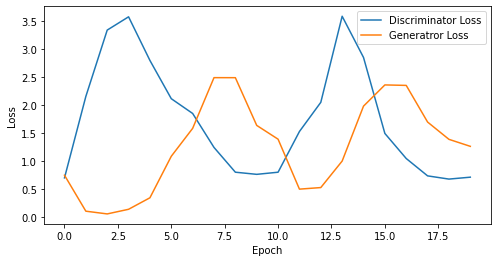

epoch: 20, Discriminator Loss: 1.74289031624794, Generator Loss: 1.2576073035597801


In [39]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []
gen_rst = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    
    # 가짜 이미지 데이터 생성
    generated_sounds = generator.predict(input_noise)
    
    # Gan에 학습할 X 데이터 정의
    x_dis = np.concatenate([sound_data, generated_sounds])
    
    # Gan에 학습할 Y 데이터 정의
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 0.9
    
    # Discriminator 훈련
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)
    
    # Gan 훈련
    noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)
    
    # Discriminator의 판별 학습을 방지합니다
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    gen_rst=np.array(generated_sounds)
    
    if(epoch==EPOCHS):
        visualize_training(epoch, d_losses, g_losses)


In [40]:
gen_rst.shape

(20, 66150)

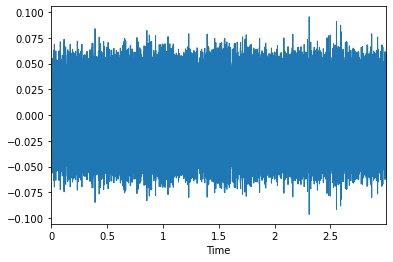

In [42]:
librosa.display.waveplot(gen_rst[19])

In [ ]:
import soundfile as sf
sf.write('./output1.wav', test, sr, subtype='PCM_24')

In [ ]:
#magnitude = np.abs(y)
log_spectrogram = librosa.amplitude_to_db(gen_rst[19].T)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogram, sr=22500, hop_length=128)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")